In [ ]:
-------------------------***** NYC Green Taxi Data *****--------------------------

In [ ]:
By Sakshi Agrawal 

In [41]:
import os
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 

import warnings
warnings.simplefilter(action='ignore')

Load data and analyze:
1. Characterize the data and comment about its quality
2. Explore and visualize the data e.g. a histogram of trip distance
3. Find interesting trip statistics grouped by hour
4. The taxi drivers want to know what kind of trip yields better tips. Can you build a model for
them and explain the model?
5. Pick one of the options below
• (Option 1) Find an anomaly in the data and explain your findings.
• (Option 2) Visualize the data to help understand trip patterns
Please submit the result in the form of runnable notebooks or

In [42]:
#Load data and analyze:
#1. Characterize the data and comment about its quality
data = pd.read_csv('green_tripdata_2016-12.csv').reset_index()
data.columns = ['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type','aa','aa2']
data = data.drop(['aa', 'aa2'],axis=1)

In [43]:
## Load Data

print('Number of rows:', data.shape[0])
print('Number of columns:', data.shape[1])

Number of rows: 1224158
Number of columns: 19


In [44]:

## Explore data
print(data.columns)
print(data.head(3))
print(data.describe())


Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type'],
      dtype='object')
   VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2016-12-01 00:00:54   2016-12-01 00:06:54                  N   
1         2  2016-12-01 00:52:41   2016-12-01 00:54:51                  N   
2         2  2016-12-01 00:10:39   2016-12-01 00:14:47                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0           1            92           192                1           1.29   
1           1            92           171                1           0.64   
2           1            75           238                2           0.89   

   fare_amo



From the above description, we can notice that some problems exist in this raw dataset:



2. Some records' payment amount is negative

3. Some records' trip type is missing

4. The whole column 'Ehail fee' is empty


In [45]:


## Since the whole column "Ehail_fee" is NaN, we can drop that column
data.drop('ehail_fee', axis=1, inplace=True)



In [46]:
## check if the records whose longitude/latitude is 0 have something to do with server connection
print('Pickup location is (0,0):')
print(data['store_and_fwd_flag'].value_counts())
print('\n')
print('Dropoff location is (0,0):')
print(data['store_and_fwd_flag'].value_counts())

Pickup location is (0,0):
N    1222074
Y       2084
Name: store_and_fwd_flag, dtype: int64


Dropoff location is (0,0):
N    1222074
Y       2084
Name: store_and_fwd_flag, dtype: int64


It seems that this problem is not related to "store and forward flag".

In [47]:


print('Trip distance description (mile):')
print(data['trip_distance'].describe())



Trip distance description (mile):
count    1.224158e+06
mean     2.618179e+00
std      2.806160e+00
min      0.000000e+00
25%      9.800000e-01
50%      1.700000e+00
75%      3.200000e+00
max      1.475000e+02
Name: trip_distance, dtype: float64


In [48]:
## check the top 10 trip distance
print('The top 10 longest trip distances:')
print(sorted(data['trip_distance'], reverse = True)[:10])


The top 10 longest trip distances:
[147.5, 133.59, 128.4, 119.1, 111.91, 101.3, 100.39, 100.1, 98.8, 95.0]


In [49]:
## Remove trip distance = 0 
print('Removing trips whose trip distance = 0 ...')
data = data[data['trip_distance'] > 0]
print('Remianing number of records:', data.shape[0])

Removing trips whose trip distance = 0 ...
Remianing number of records: 1208975


Text(0, 0.5, 'Count')

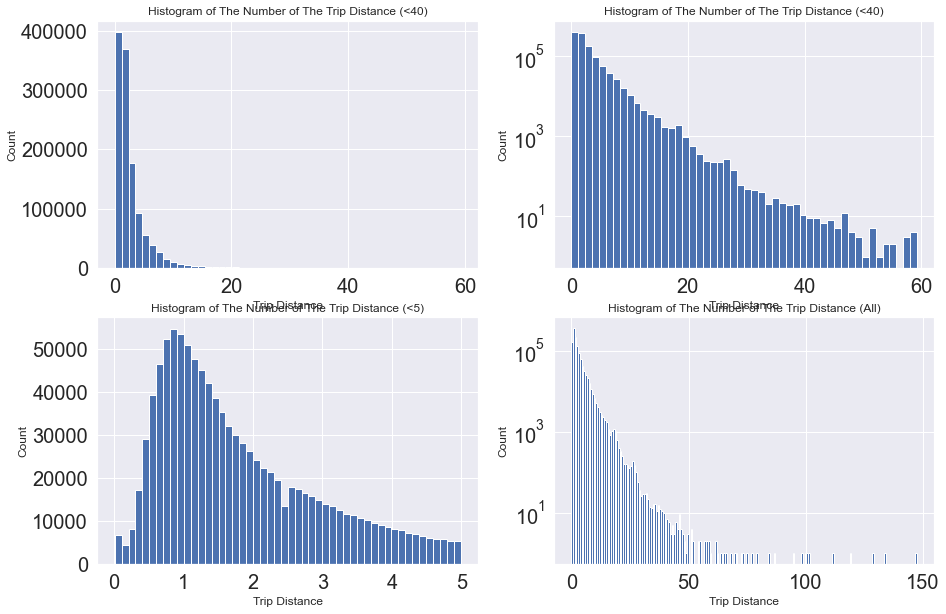

In [50]:
## To make the figures clear, let's only see the ones with trip distance < some threshold.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15,10))

data['trip_distance'][data['trip_distance'] < 60].hist(ax=ax1, bins=50)
ax1.set_title('Histogram of The Number of The Trip Distance (<40)')
ax1.set_xlabel('Trip Distance')
ax1.set_ylabel('Count')

data['trip_distance'][data['trip_distance'] < 60].hist(ax=ax2, bins=50)
ax2.set_yscale('log')
ax2.set_title('Histogram of The Number of The Trip Distance (<40)')
ax2.set_xlabel('Trip Distance')
ax2.set_ylabel('Count')


data['trip_distance'][data['trip_distance'] < 5].hist(ax=ax3, bins=50)
ax3.set_title('Histogram of The Number of The Trip Distance (<5)')
ax3.set_xlabel('Trip Distance')
ax3.set_ylabel('Count')

data['trip_distance'].hist(ax=ax4, bins=200)
ax4.set_yscale('log')
ax4.set_title('Histogram of The Number of The Trip Distance (All)')
ax4.set_xlabel('Trip Distance')
ax4.set_ylabel('Count')



From the above figures, we can see that:

    When trip distance > 1, as the trip distance increases, its count decreases;

    when trip distance < 1, as the trip distance increases, its count increases.

In reality, it makes sense that most taxi trips are short trips（aruound 1-2 miles). Becuase for long trips, it would be expensive to take a taxi, and people probably would choose public transportations like metro or bus to save their money. While for short trips, people probably prefer to choose taxi to save their time.

Hypotheses:

    When 1 < trip distance < 60, the relation between trip distance (TD) and its log(count) is almost linear. In other words, we can represent it as $TD = b - a*log(count)$.



In [51]:
data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type
0,2,2016-12-01 00:00:54,2016-12-01 00:06:54,N,1,92,192,1,1.29,6.5,0.5,0.5,0.00,0.0,0.3,7.80,2,1
1,2,2016-12-01 00:52:41,2016-12-01 00:54:51,N,1,92,171,1,0.64,4.0,0.5,0.5,1.06,0.0,0.3,6.36,1,1
2,2,2016-12-01 00:10:39,2016-12-01 00:14:47,N,1,75,238,2,0.89,5.5,0.5,0.5,1.70,0.0,0.3,8.50,1,1
3,2,2016-12-01 00:12:16,2016-12-01 00:15:31,N,1,166,151,1,0.66,4.5,0.5,0.5,1.74,0.0,0.3,7.54,1,1
4,2,2016-12-01 00:29:22,2016-12-01 00:39:51,N,1,166,42,1,2.15,9.5,0.5,0.5,2.16,0.0,0.3,12.96,1,1


In [52]:
data.shape

(1208975, 18)

In [53]:
#2. Explore and visualize the data e.g. a histogram of trip distance

Text(0, 0.5, 'Count')

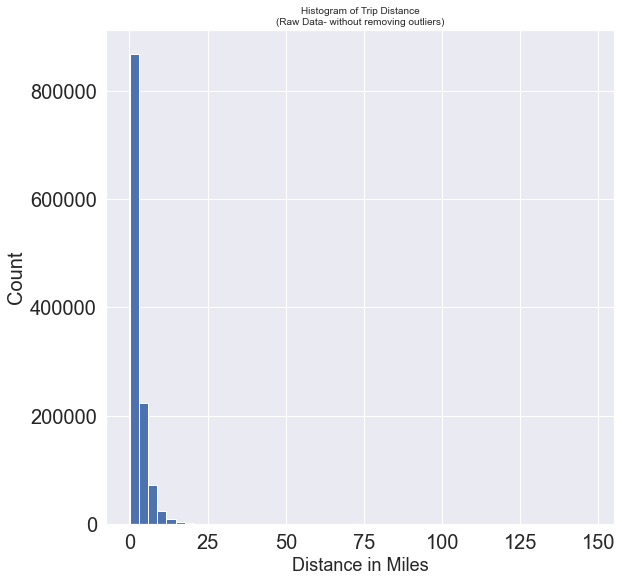

In [54]:
import seaborn as sns
import matplotlib.mlab as mlab
import scipy.stats as stat
import matplotlib

sns.set()
matplotlib.rc('xtick', labelsize=20)     
matplotlib.rc('ytick', labelsize=20)
plt.figure(1,figsize=(20,20))

plt.subplot(221)
plt.hist(data['trip_distance'],bins=50)
plt.title('Histogram of Trip Distance\n(Raw Data- without removing outliers)',size=10)
plt.xlabel("Distance in Miles",size=18)
plt.grid(True)
plt.ylabel("Count",size=20)

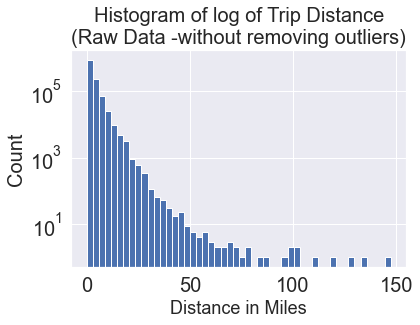

In [55]:
# plt.subplot(222)
plt.hist(data['trip_distance'],log=True,bins=50)
plt.title('Histogram of log of Trip Distance\n(Raw Data -without removing outliers)',size=20)
plt.xlabel("Distance in Miles",size=18)
plt.ylabel("Count",size=20)
plt.grid(True)


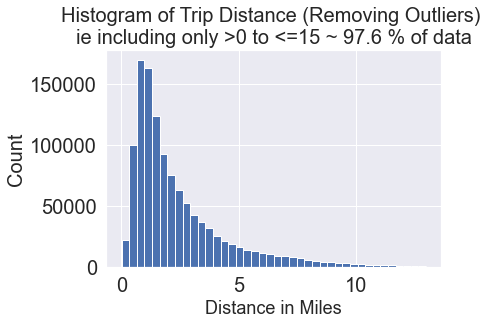

In [56]:
data_subset1 = data[(data['trip_distance'] >0) & (data['trip_distance'] <= 13)]

# plt.subplot(223)
plt.hist(data_subset1['trip_distance'],bins=40)
plt.title('Histogram of Trip Distance (Removing Outliers) \nie including only >0 to <=15 ~ 97.6 % of data',size=20)
plt.xlabel("Distance in Miles",size=18)
plt.ylabel("Count",size=20)
plt.grid(True)


In [57]:
data['trip_distance'].value_counts()

0.90     15655
0.80     15398
1.00     15304
1.10     14173
0.70     14032
         ...  
43.61        1
24.74        1
23.58        1
25.12        1
54.06        1
Name: trip_distance, Length: 3051, dtype: int64

In [58]:
import datetime
data['hour']=[ t.hour for t in pd.to_datetime(data['lpep_pickup_datetime'])]
data['hour']

0           0
1           0
2           0
3           0
4           0
           ..
1224153    23
1224154    23
1224155    23
1224156    23
1224157    23
Name: hour, Length: 1208975, dtype: int64

In [59]:
#3. Find interesting trip statistics grouped by hour 
df_hour=pd.DataFrame()
df_hour['Hour']=range(0,24)
df_hour['Mean_distance']=data.groupby('hour').mean()['trip_distance']
df_hour['Median_distance']=data.groupby('hour').median()['trip_distance']
df_hour.head()

,Hour,Mean_distance,Median_distance
0,0,2.843735,1.89
1,1,2.840485,1.90
2,2,2.930142,1.97
3,3,3.074430,2.08
4,4,3.352629,2.20


In [60]:
data['trip_distance'].value_counts()

0.90     15655
0.80     15398
1.00     15304
1.10     14173
0.70     14032
         ...  
43.61        1
24.74        1
23.58        1
25.12        1
54.06        1
Name: trip_distance, Length: 3051, dtype: int64

In [61]:
data['RatecodeID'].value_counts()

1    1186681
5      18095
2       2768
3        740
4        679
6         12
Name: RatecodeID, dtype: int64

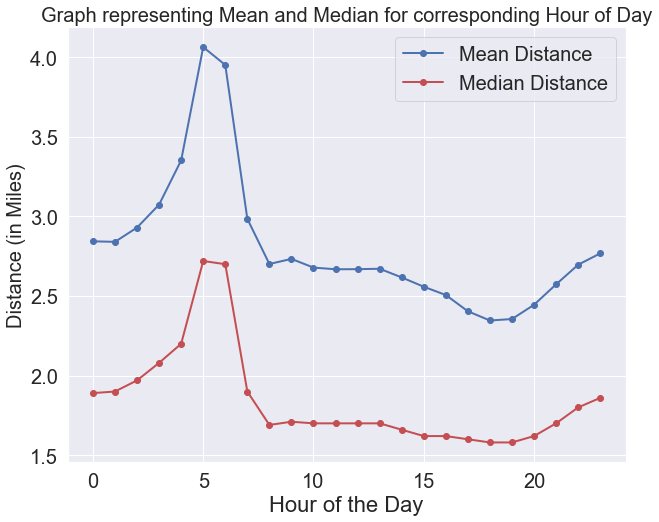

In [62]:
plt.figure(figsize=(10,8))
plt.plot(df_hour['Hour'],df_hour['Mean_distance'],'bo-',linewidth=2,label='Mean Distance')
plt.plot(df_hour['Hour'],df_hour['Median_distance'],'ro-',linewidth=2,label='Median Distance')
plt.legend(loc='upper right',fontsize=20)
plt.title('Graph representing Mean and Median for corresponding Hour of Day',size=20)
plt.xlabel("Hour of the Day",size=22)
plt.ylabel("Distance (in Miles)",size=20)
plt.grid(True)


Text(0, 0.5, 'Trip Distance')

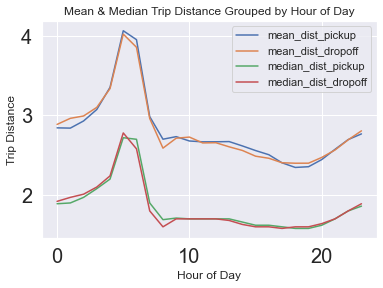

In [63]:
## There are only two variables are related to time in this dataset: 
## 'lpep_pickup_datetime' and 'Lpep_dropoff_datetime'.

## extract the hour of day from pickup datetime and dropoff datetime
data['pickup_hour'] = pd.DatetimeIndex(data['lpep_pickup_datetime']).hour
data['dropoff_hour'] = pd.DatetimeIndex(data['lpep_dropoff_datetime']).hour

## group by hour, get the mean 
mean_dist_pickup = data['trip_distance'].groupby(data['pickup_hour']).mean()
mean_dist_dropoff = data['trip_distance'].groupby(data['dropoff_hour']).mean()

## group by hour, get the median
median_dist_pickup = data['trip_distance'].groupby(data['pickup_hour']).median()
median_dist_dropoff = data['trip_distance'].groupby(data['dropoff_hour']).median()

## create a dataframe to store them
df = pd.concat([mean_dist_pickup, mean_dist_dropoff,
                median_dist_pickup, median_dist_dropoff], axis=1)
df.columns = ['mean_dist_pickup', 'mean_dist_dropoff',
              'median_dist_pickup', 'median_dist_dropoff']


## visualize the dataframe
ax = df.plot(title='Mean & Median Trip Distance Grouped by Hour of Day')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best') 
# ax.set_xticks(np.arange(24))
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Trip Distance")



From the above figure, we can see that

    the trip distance grouped by hour of day calculated from pickup and dropoff are similar;

    the median trip distance is always lower than the mean trip distance;

    the mean and median trip distances have similar trends, and we can separate the time into three parts:
        trip distance appears to be the longest during 4am-6am;
        trip distance appears to be the shortest during 7am-9pm;
        trip distance appears to be medium during 9pm-4am.

In [64]:


# According to http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml,
# the initial charge is $2.50, so remove trips whose total amount < 2.5.
print('Removing trips whose total amount < $2.5  ...')
data = data[data['total_amount'] > 2.5]
print('Remianing number of records:', data.shape[0])



Removing trips whose total amount < $2.5  ...
Remianing number of records: 1204232


In [65]:
data['Tip_%']=100*data['tip_amount']/data['total_amount']
print("Initially there are {} NA Values ".format(data['Tip_%'].isna().sum()))
data['Tip_%'] = data['Tip_%'].fillna(data['Tip_%'].mean())

Initially there are 0 NA Values 


In [66]:
data['Tip_%'].value_counts()

0.000000     714038
16.666667    120567
16.666667     66162
20.000000     25990
23.076923     24732
              ...  
2.339181          1
19.312775         1
0.132275          1
6.256934          1
2.214022          1
Name: Tip_%, Length: 10967, dtype: int64

In [67]:
(100*data['Tip_%'].round().value_counts()/len(data)).round().iloc[:10]

0.0     59.0
17.0    20.0
20.0     5.0
23.0     3.0
13.0     1.0
14.0     1.0
11.0     1.0
9.0      1.0
15.0     1.0
12.0     1.0
Name: Tip_%, dtype: float64

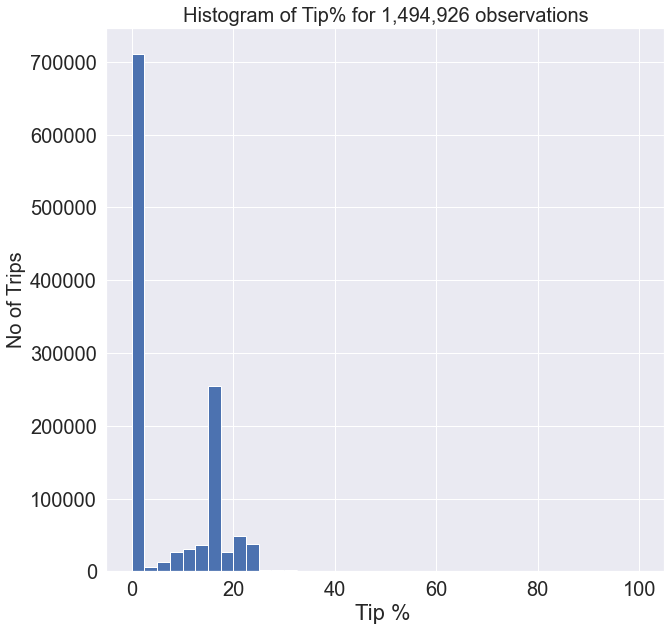

In [82]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
matplotlib.rc('xtick', labelsize=20)     
matplotlib.rc('ytick', labelsize=20)
plt.figure(figsize=(10,10))
plt.hist(data['Tip_%'],bins=40)
plt.title('Histogram of Tip% for 1,494,926 observations',size=20)
plt.xlabel("Tip % ",size=22)
plt.ylabel("No of Trips",size=20)
plt.grid(True)

In [83]:
## According to the document http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf
## RateCodeID 2 represents JFK Airport, and RateCodeID 3 represents Newark Airport

## Here I choose to only consider the trips originate or terminate at JFK Airport
print('Number of transactions of trips that originate or terminate at JFK Airport: %d.' 
      % data[data['RatecodeID']==2].shape[0])
print('The average fare amount of these transactions is: $%.2f.' 
      % data['fare_amount'][data['RatecodeID']==2].mean())
print('The average total amount of these transactions is: $%.2f. \n' 
      % data['total_amount'][data['RatecodeID']==2].mean())

Number of transactions of trips that originate or terminate at JFK Airport: 2700.
The average fare amount of these transactions is: $52.00.
The average total amount of these transactions is: $64.05. 



Fare amount:
52.0    2700
Name: fare_amount, dtype: int64

Extra amount:
0.0    2152
4.5     548
Name: extra, dtype: int64

MTA tax amount:
0.5    2693
0.0       7
Name: mta_tax, dtype: int64

Improve_surcharge:
0.3    2683
0.0      17
Name: improvement_surcharge, dtype: int64


Text(0.5, 1.0, 'Tip Amount Distribution')

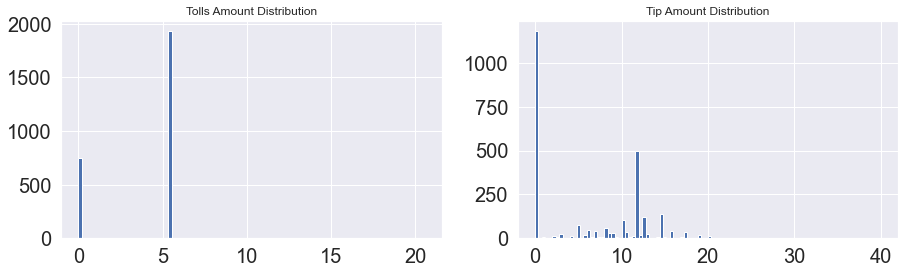

In [84]:
## Check the fare of JFK Airports
print('Fare amount:')
print(data['fare_amount'][data['RatecodeID']==2].value_counts())

print('\nExtra amount:')
print(data['extra'][data['RatecodeID']==2].value_counts())

print('\nMTA tax amount:')
print(data['mta_tax'][data['RatecodeID']==2].value_counts())

print('\nImprove_surcharge:')
print(data['improvement_surcharge'][data['RatecodeID']==2].value_counts())

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,4))
data['tolls_amount'][data['RatecodeID']==2].hist(ax=ax1, bins=100)
ax1.set_title('Tolls Amount Distribution')

data['tip_amount'][data['RatecodeID']==2].hist(ax=ax2, bins=100)
ax2.set_title('Tip Amount Distribution')

The fare amount of JFK trips is a fixed value: $52. The main cause of different total amount is tolls amount and tip amount. Let's check whether the tip amount has something to do with the hour of a day.

Text(0, 0.5, 'Trip Count')

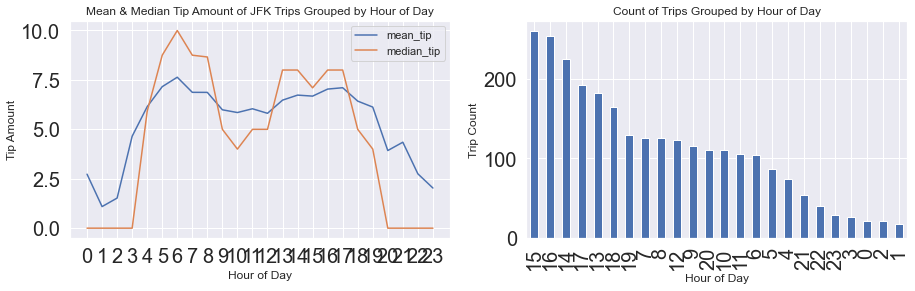

In [85]:
## Let's check whether the tip amount has something to do with the hour of a day.

## create a subset of JFK trips
df_jfk = data[data['RatecodeID']==2]

## Since most trips' pickup hour and dropoff hour are the same, we only use the pickup hour here.
## calculate the mean and median tip amount group by pickup hour of a day
mean_tip_jfk = df_jfk['tip_amount'].groupby(df_jfk['pickup_hour']).mean()
median_tip_jfk = df_jfk['tip_amount'].groupby(df_jfk['pickup_hour']).median()
mean_tip_jfk.name = 'mean_tip'
median_tip_jfk.name = 'median_tip'

## plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4))
mean_tip_jfk.plot(ax=ax1)
median_tip_jfk.plot(ax=ax1)
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best') 
ax1.set_xticks(np.arange(24))
ax1.set_title("Mean & Median Tip Amount of JFK Trips Grouped by Hour of Day")
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Tip Amount")

## plot
df_jfk['pickup_hour'].value_counts().plot.bar(ax=ax2)
ax2.set_title("Count of Trips Grouped by Hour of Day")
ax2.set_xlabel("Hour of Day")
ax2.set_ylabel("Trip Count")

From the above figure, we can conclude that the value of tip amount does have something to do with the hour of a day.

It is interesting that in most hours, the median of the tip amount is zero.
Both of the mean tip amount line and the median amount line show that one peak time of high tip amount is around 5:00-8:00, and the other peak time is around 14:00-15:00. From the right figure, we can see that 14:00-16:00 is the rush hour of a day. So, people probably give high tips because of heavy traffic.

In [86]:
# create a subset called df_tip with payment type = 1 (credit card)
print('Keep trips paid by credit card ...')
df_tip = data[data['payment_type'] == 1]
print('Remianing number of records: ', df_tip.shape[0])

Keep trips paid by credit card ...
Remianing number of records:  571661


Trip duration description (minutes):
min    0.000278
25%    0.097222
50%    0.161111
75%    0.266111
max    4.995833
Name: duration, dtype: float64
Remove trips whose duration > 5 hours and keep trips whose duration > 0 ...
Remaining number of records:  1196362


Text(0.5, 0.98, 'Histogram of Trip Duration (hour)')

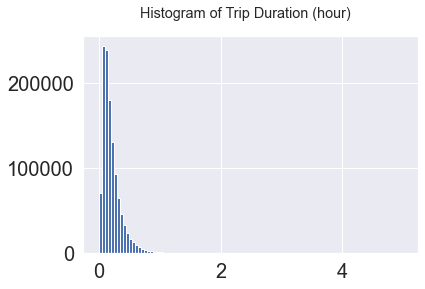

In [87]:
## Before building the model, let's create new features: trip duration and averge speed

## Create a new feature: trip duration
data['duration'] = pd.to_datetime(data['lpep_dropoff_datetime']) - \
                    pd.to_datetime(data['lpep_pickup_datetime'])
data['duration'] = data['duration'] / np.timedelta64(1, 'h') # convert to minutes

print('Trip duration description (minutes):')
print(data['duration'].describe()[3:])

## it is abnormal that a trip's duration is more than 5 hours, so remove them
print('Remove trips whose duration > 5 hours and keep trips whose duration > 0 ...')
data = data[data['duration'] < 5]
data = data[data['duration'] > 0]
print('Remaining number of records: ', data.shape[0])

data['duration'].hist(bins=100)
plt.suptitle('Histogram of Trip Duration (hour)')

Text(0.5, 0, 'Payment (1=Credit card, 2=Cash, 3=No charge, 4=Dispute, 5=Unknown)')

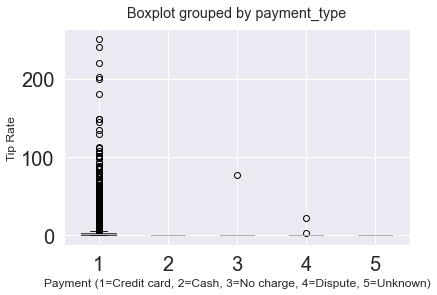

In [88]:


## check the relationship between payment type and tip
ax = plt.subplot()
data.boxplot('tip_amount','payment_type', ax=ax)
ax.set_title('')
ax.set_ylabel('Tip Rate')
ax.set_xlabel('Payment (1=Credit card, 2=Cash, 3=No charge, 4=Dispute, 5=Unknown)')


From the figure above, we can see that the average tip amount of trips paid by credit card is bigger than zero, while others are zero. It makes sense since the tip amount is automatically populated for credit card tips, while cash tips are not included. So, let's only keep the trips paid by credit card.



# create a subset called df_tip with payment type = 1 (credit card)
print('Keep trips paid by credit card ...')
df_tip = data[data['payment_type'] == 1]
print('Remianing number of records: ', df_tip.shape[0])



In [89]:
## Accoring to the handbook, fare amount is the time-and-distance fare calculated by the meter.
## Let's integrate other fare amount EXCEPT TIP AMOUNT into one variable called "other_amount".
df_tip['other_amount'] = df_tip['extra'] + df_tip['mta_tax'] + \
                         df_tip['tolls_amount'] + df_tip['improvement_surcharge']
    
print('Other amount description ($):')
print(df_tip['other_amount'].describe()[3:])

Other amount description ($):
min     0.0
25%     0.8
50%     1.3
75%     1.3
max    97.3
Name: other_amount, dtype: float64


In [90]:
# create a variable "tip rate", that is, the percentage of tip amount over the total amount
print('Define tip rate as the percentage of tip amount over the total amount. \n')
df_tip['tip_rate'] = 100*df_tip['tip_amount']/df_tip['total_amount']
print('Tip rate description (%):')
print(df_tip['tip_rate'].describe()[3:])
print('\n')

# check the number of trips without tip
print('Number of trips with zero tips: ', df_tip[df_tip['tip_rate']==0].shape[0])
print('The percentage of trips with zero tips: ',
     round(100*df_tip[df_tip['tip_rate']==0].shape[0]/df_tip.shape[0],2), '%')

Define tip rate as the percentage of tip amount over the total amount. 

Tip rate description (%):
min      0.000000
25%     11.019284
50%     16.666667
75%     16.666667
max    100.000000
Name: tip_rate, dtype: float64


Number of trips with zero tips:  83676
The percentage of trips with zero tips:  14.64 %


It is interesting that about 14.73% of trips' tip amount is zero in this subset.

In [91]:
df_tip['trip_type'].value_counts()

1    566634
2      5027
Name: trip_type, dtype: int64

Text(0.5, 0, 'Pickup Hour')

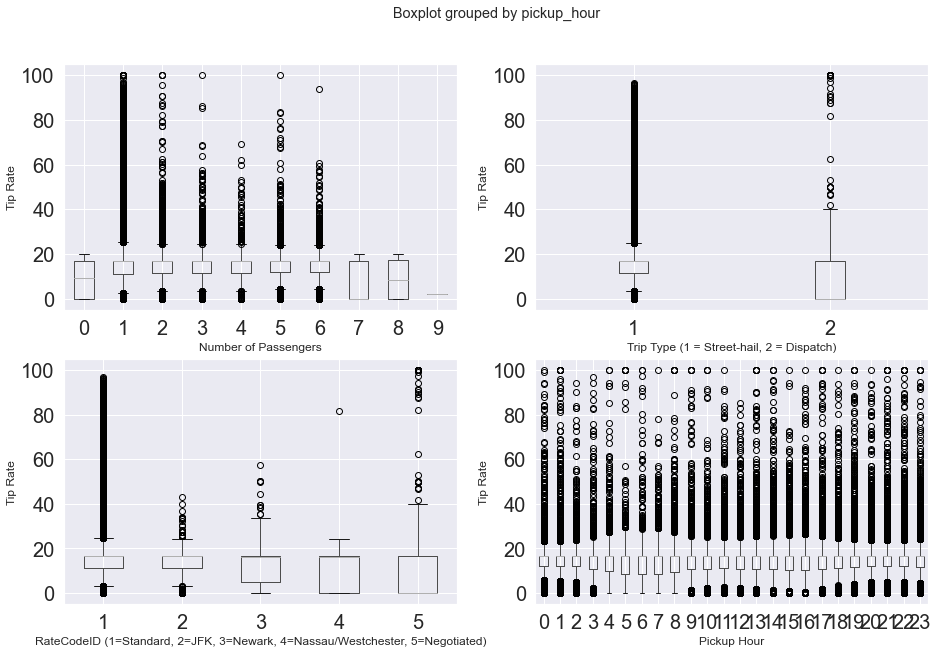

In [92]:
## More exploration about the relation between features and target
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,10))

df_tip.boxplot('tip_rate','passenger_count', ax=ax1)
ax1.set_title('')
ax1.set_ylabel('Tip Rate')
ax1.set_xlabel('Number of Passengers')

df_tip.boxplot('tip_rate','trip_type', ax=ax2)
ax2.set_title('')
ax2.set_ylabel('Tip Rate')
ax2.set_xlabel('Trip Type (1 = Street-hail, 2 = Dispatch)')

df_tip.boxplot('tip_rate','RatecodeID', ax=ax3)
ax3.set_title('')
ax3.set_ylabel('Tip Rate')
ax3.set_xlabel('RateCodeID (1=Standard, 2=JFK, 3=Newark, 4=Nassau/Westchester, 5=Negotiated)')

df_tip.boxplot('tip_rate','pickup_hour', ax=ax4)
ax4.set_title('')
ax4.set_ylabel('Tip Rate')
ax4.set_xlabel('Pickup Hour')

It seems that the tip rate distributions of 1 to 6 passengers are similar. However, for 7-9 passengers, the distributions change dramatically, and this is caused by not enough records. According to the handbook, the number of passengers is a driver-entered value, and this explains why some values are zero since the driver did not enter it correctly. Since there is no strong evidence that the number of passengers effect tip rate, I am not going to use this feature for the following predictive model.

It seems that street-hail trips tend to have higher tip rate than dispatch trips.

It seems that standard trips and JFK trips have higher tip rate than others.

It seems that pickup hour does effect trip rate.

Text(0.5, 1.0, 'Trip Rate vs Other Amount')

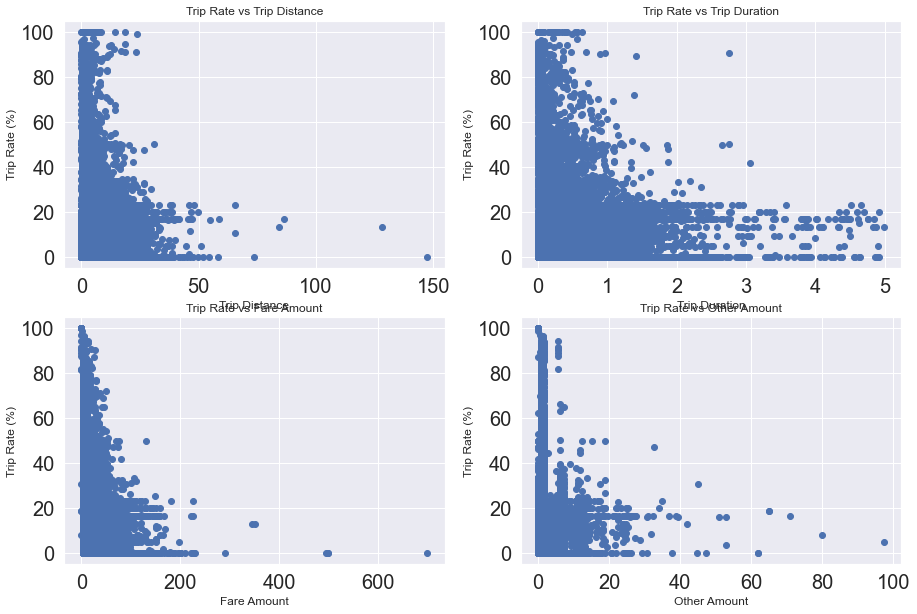

In [93]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,10))

ax1.scatter(df_tip['trip_distance'], df_tip['tip_rate'])
ax1.set_xlabel('Trip Distance')
ax1.set_ylabel('Trip Rate (%)')
ax1.set_title('Trip Rate vs Trip Distance')

ax2.scatter(df_tip['duration'], df_tip['tip_rate'])
ax2.set_xlabel('Trip Duration')
ax2.set_ylabel('Trip Rate (%)')
ax2.set_title('Trip Rate vs Trip Duration')

ax3.scatter(df_tip['fare_amount'], df_tip['tip_rate'])
ax3.set_xlabel('Fare Amount')
ax3.set_ylabel('Trip Rate (%)')
ax3.set_title('Trip Rate vs Fare Amount')

ax4.scatter(df_tip['other_amount'], df_tip['tip_rate'])
ax4.set_xlabel('Other Amount')
ax4.set_ylabel('Trip Rate (%)')
ax4.set_title('Trip Rate vs Other Amount')

Build Model

In [94]:
## Choose features

# numerical features
X_num = ['trip_distance', 'duration','fare_amount', 'other_amount', 'pickup_hour']
# one-hot encoding for categorical feature Trip_type
df_tip['trip_type_1'] = (df_tip['trip_type'] == 1.0).astype(int)
df_tip['trip_type_2'] = (df_tip['trip_type'] == 2.0).astype(int)

# one-hot encoding for categorical feature RatecodeID
df_tip['rate_code_1'] = (df_tip['RatecodeID'] == 1).astype(int)
df_tip['rate_code_2'] = (df_tip['RatecodeID'] == 2).astype(int)
df_tip['rate_code_3'] = (df_tip['RatecodeID'] == 3).astype(int)
df_tip['rate_code_4'] = (df_tip['RatecodeID'] == 4).astype(int)
df_tip['rate_code_5'] = (df_tip['RatecodeID'] == 5).astype(int)

# final categorical features
X_cat = ['trip_type_1', 'trip_type_2', 
         'rate_code_1', 'rate_code_2', 'rate_code_3', 'rate_code_4', 'rate_code_5']

In [95]:
# only use numerical features as X for linear regression model
X_lm = df_tip[X_num]

# target y
y = df_tip['tip_rate']

## Use the package "stats" since it provides p-values of coefficients automatically
import statsmodels.api as sm
from scipy import stats

est = sm.OLS(y, sm.add_constant(X_lm))
print(est.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               tip_rate   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     801.9
Date:                Tue, 03 May 2022   Prob (F-statistic):               0.00
Time:                        15:19:01   Log-Likelihood:            -1.9613e+06
No. Observations:              571661   AIC:                         3.923e+06
Df Residuals:                  571655   BIC:                         3.923e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            14.6138      0.028    515.377



The p-value of the variable of trip duration is too large (bigger than 0.05), so remove this variable and run the linear regression model again.


In [96]:


## remove the column of trip duration and run the model again
X_lm = X_lm[['trip_distance','fare_amount','other_amount','pickup_hour']]
est2 = sm.OLS(y, sm.add_constant(X_lm))
print(est2.fit().summary())



                            OLS Regression Results                            
Dep. Variable:               tip_rate   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     996.0
Date:                Tue, 03 May 2022   Prob (F-statistic):               0.00
Time:                        15:19:07   Log-Likelihood:            -1.9613e+06
No. Observations:              571661   AIC:                         3.923e+06
Df Residuals:                  571656   BIC:                         3.923e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            14.6179      0.028    515.723



Now all the p-values of all four variables' coefficients are statistically significant. Next, use the package "sklearn" to split the dataset into a training dataset and a test dataset (80% : 20%), and calculate the MAE and RMSE for them.


Cross validation (10-fold) on the training dataset:
Mean Absolute Error (MAE): 5.59
Root Mean Squared Error (RMSE): 7.47


Results on the test dataset:
Mean Absolute Error (MAE): 5.59
Root Mean Squared Error (RMSE): 7.49


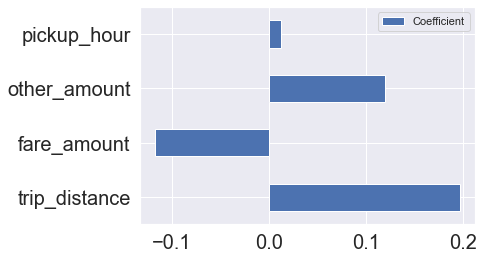

In [97]:
## Split data into a training dataset and a test dataset (8:2)
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X_lm, y, test_size=0.2, random_state=0) 

## Linear Regression Model
lm = LinearRegression(normalize=True)
lm.fit(X_train, y_train) 

df_feat_impt = pd.DataFrame(lm.coef_, X_lm.columns, columns=['Coefficient'])
df_feat_impt.plot.barh()

## results on the training dataset
scores_MAE = cross_val_score(lm, X_lm, y, cv=10, scoring='neg_mean_squared_error')
scores_MSE = cross_val_score(lm, X_lm, y, cv=10, scoring='neg_mean_squared_error')
print('Cross validation (10-fold) on the training dataset:')
print("Mean Absolute Error (MAE): %0.2f" % (-scores_MAE*0.1).mean())
print("Root Mean Squared Error (RMSE): %0.2f" % np.sqrt(-scores_MSE).mean())
print('\n')

## results on the test dataset
y_pred_test = lm.predict(X_test)

print('Results on the test dataset:')
print("Mean Absolute Error (MAE): %0.2f" %  metrics.mean_absolute_error(y_test, y_pred_test)) 
print("Root Mean Squared Error (RMSE): %0.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))  

The training results calculated by 10-fold cross validation: MAE: 5.44, RMSE: 7.35.
The test results: MAE: 5.42, RMSE: 7.34.

Tip rate has a positive correlation with trip distance and other amount (total amount - tip amount - fare amount). Tip rate has a negative correlation with fare amount.

We have already explored the relation between the tip rate and the hour of day, and we have found that their relation is not linear. It makes sense that the coefficient of the variable "pickup hour" is so close to zero.



In [ ]:
# use both numerical and categorical features as X for regression random forest model
X_feat = X_cat + X_num
X = df_tip[X_feat]

# target y
y = df_tip['tip_rate']

## Split data into a training dataset and a test dataset (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

## Random Forest Regression Model
regressor = RandomForestRegressor(max_depth=8)  
regressor.fit(X_train, y_train) 

df_feat_impt = pd.DataFrame(regressor.feature_importances_, X.columns, columns=['Coefficient'])
df_feat_impt.plot.barh()

## results on the training dataset
from sklearn.model_selection import cross_val_score
scores_MAE = cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores_MSE = cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print('Cross validation (5-fold) on the training dataset:')
print("Mean Absolute Error (MAE): %0.2f" % (-scores_MAE).mean())
print("Mean Squared Error (MSE): %0.2f" % np.sqrt(-scores_MSE).mean())
print('\n')

## results on the test dataset
y_pred_test = regressor.predict(X_test)

print('Results on the test dataset:')
print("Mean Absolute Error (MAE)%0.2f" %  metrics.mean_absolute_error(y_test, y_pred_test)) 
print("Root Mean Squared Error (RMSE): %0.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))) 



The results of this random forest regression model are better than the ones of the linear regression model, since the root mean squared errors (RMSE) and the mean absolute errors (MAE) are slightly lower than the ones of the linear regression model. So, we should use this model to predict the tip rate of trips.

    The training results calculated by 10-fold cross validation: MAE: 5.40, RMSE: 7.20.

    The test results: MAE: 5.37, RMSE: 7.18.

    Fare amount and other amount are the top 2 features affect tip rate in this regression random forest model, and this correspond with the results of the linear regression model.

    Duration, trip distance, and pickup hour also affect the trip rate.

    It is interesting that negotiated trips (RodeCodeID=5) affect tip rate.

Question 5: Option A: Distributions

• Build a derived variable representing the average speed over the course of a trip.

At the beginning of question 4, We have already deefined average speed over the course of a trip as Trip Distance/Trip Duration, and its unit is mile per hour (mph).
